In [10]:
import torch
import numpy as np
import re
from collections import Counter
import nltk
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from string import punctuation

In [11]:
def read(path):
    file = open(path, encoding='utf8')
    lines = [line for line in file.readlines()]
    file.close()
    return lines

In [12]:
train_negative = 'train_negative_tokenized.txt'
train_neural = 'train_neutral_tokenized.txt'
train_positive = 'train_neutral_tokenized.txt'

In [13]:
negative = read(train_negative)
neural = read(train_neural)
positive = read(train_negative)

In [14]:
train_set = negative + neural + positive

# bỏ những dòng trống
train_set = [i for i in train_set if i != '\n']
size = len(train_set)

# đưa tất cả về chữ thường 
for i in range(size):
    train_set[i] = train_set[i].lower()

# bỏ các ký tự unicode
for i in range(size):
    train_set[i] = train_set[i].replace('\ufeff', '').replace('\xa0', '').replace('\u200e', '').replace('\u200b', '').replace('\n', '')

# bỏ các chuỗi mặt cười
for i in range(size):
    train_set[i] = re.sub(r':(\s*\))+\s', '', train_set[i])

# bỏ các chuỗi '...'
for i in range(size):
    train_set[i] = re.sub(r':(\s*\))+\s', '', train_set[i])


In [15]:
vocab = Counter()

for i, sentence in enumerate(train_set):
    train_set[i] = []
    for word in nltk.word_tokenize(sentence):  # Tokenizing the words
        vocab.update([word]) # cập nhật số lần xuất hiện của word
        train_set[i].append(word)

In [18]:
for k in punctuation:
    del vocab[k]

In [125]:
# vocab = [k for k in vocab if k not in punctuation] # bỏ các dấu chấm câu

In [19]:
vocab_ = sorted(vocab, key=vocab.get, reverse=True) # sắp xếp theo thứ tự tần suất xuất hiện giảm dần

In [21]:
w2i = {w:i+1 for i,w in enumerate(vocab)} # w2i[word] ->  mức độ xuất hiện word trong corpus
# (1 là xuất hiện nhiều nhất, số 0 để padding)
i2w = {i+1:w for i,w in enumerate(vocab)}

In [24]:
train_set_vct = np.empty_like(train_set)
for i, sentence in enumerate(train_set):
    train_set_vct[i] = [w2i[word] if word in w2i else 0 for word in sentence] # thay từ bằng w2i của từ, nếu không trong corpus -> 0

In [25]:
count = np.zeros(len(train_set_vct))
for s in train_set_vct:
    count[len(s)] += 1

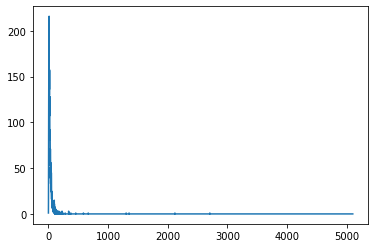

In [26]:
plt.plot(count)
# plt.xlim((0,250))
plt.show() # phân bố độ dài các câu

In [27]:
normalized_len = 150 # đa số câu đều < 150, chuẩn hóa độ dài câu về 150

In [28]:
def normalize_length(sentences, seq_length):
    features = np.zeros((len(sentences), seq_length), dtype=int)
    
    for i, review in enumerate(sentences):
        review_len = len(review)
        
        if review_len <= seq_length: # ngắn hơn seq_length -> chèn thêm 0 vào đầu
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length: # dài hơn -> chỉ lấy <seq_length> số đầu tiên
            new = review[0:seq_length]
        
        features[i] = np.array(new)
    return features

In [29]:
train_set_vct_normalized = normalize_length(train_set_vct, normalized_len)

In [30]:
labels = np.ones(len(train_set_vct_normalized))
labels[:1700] = -1 # negative
labels[1700:3400] = 0 # neural

In [32]:
train_data = TensorDataset(torch.from_numpy(train_set_vct_normalized), torch.from_numpy(labels))

In [33]:
bs = 20

train_loader = DataLoader(train_data, shuffle=True, batch_size=bs)

In [34]:
examples = iter(train_loader)
sentences, ground_truth = examples.next()

print(sentences)
print(ground_truth)

tensor([[   0,    0,    0,  ...,  181, 1141,    0],
        [   0,    0,    0,  ...,    9,   67,    0],
        [   0,    0,    0,  ...,    0,    0,    0],
        ...,
        [   0,    0,    0,  ..., 1172, 5916, 2051],
        [   0,    0,    0,  ..., 1958,  330,    0],
        [   0,    0,    0,  ...,  829,  568,    0]])
tensor([ 0., -1.,  1.,  1.,  1.,  0., -1.,  1., -1., -1.,  1., -1.,  0.,  0.,
         0.,  1., -1.,  0.,  1.,  1.], dtype=torch.float64)


In [35]:
decoded_sentence = [i2w[w.item()] for w in sentences[2] if w != 0]
print(decoded_sentence)

['100', 'là', 'cái', 'này', 'éo', 'được', 'ưa_chuộng', 'ở', 'vn', 'từ', 'tính_năng', 'cho_đến', '...', 'mọi', 'thứ', 'tính_năng', 'thì', 'chúng_ta', 'đã', 'rõ', 'nó', 'cũng_như', 'nhiều', 'sw', 'khác', 'chỉ', 'hỗ_trợ', 'tốt', 'ở', 'mỹ', 'vs', 'một_số', 'nước', 'tư_bản', 'giẫy', 'chết', 'khác', 'về', 'việc', 'dùng', 'giang_hồ', 'dồn', 'tiền', 'mua', 'cái', '6_plus', 'phần_lớn', 'đến', 'đám', 'đông', 'để', 'khoe', 'dùng', 'cái', 'này', 'thì', 'khoe', 'cái', '6_plus', '6_s_plus', 'thế', 'quái', 'nào', 'được', 'không', 'lẻ', 'vừa', 'nhìn', 'đồng_hồ', 'vừa', 'móc', 'điện_thoại', 'nhìn']


In [36]:
print(sentence)

['cẩn_thận', 'china', 'cài', 'phần_mềm', 'gián_điệp', '!']
